In [1]:
import xarray as xr
import fsspec
import s3fs
import os
import matplotlib.pyplot as plt
import dask
import rasterio
from dask.distributed import Client, LocalCluster, progress
import datetime
import tempfile
import boto3
import geoviews as gv
from geoviews import opts

gv.extension('matplotlib')

gv.output(size=150)

run conda install -c pyviz geoviews-core

In [2]:
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

In [3]:
def convert_full_date_to_continous_day(year, month, day):
    """
    Helper function if you wish to use month, day vs julian day
    """
    return datetime.datetime(year, month, day).timetuple().tm_yday

def get_geo_uri(year, day):
    """
    returns list of geo uris
    """
    fs = s3fs.S3FileSystem(anon=True)
    files = []
    
    filepath = "s3://noaa-goes17/ABI-L2-FDCC/%s/%s/*/*.nc" % (str(year).zfill(4), str(day).zfill(3)) 
    files = fs.glob(filepath)
    
    if len(files) < 1:
        raise Exception("No files found")
    
    return files

def download_to_xarray(uri):
    """
    Downloads file and directly loads it into xarray in memory
    """
    s3 = boto3.client("s3")
    
    with tempfile.NamedTemporaryFile() as temp_file:
        s3.download_file(Bucket=uri[:11], Key=uri[12:], Filename=temp_file.name)
        datastore = xr.open_dataset(temp_file.name)
        
    return datastore

def download_to_disk(uri):
    s3 = boto3.client("s3")
    filename = uri[12:].replace("/", "-")
    if not os.path.exists(filename):
        s3.download_file(Bucket=uri[:11], Key=uri[12:], Filename=filename)
        
    return filename

In [4]:
#TUBBS = {"year": 2017, "day1":220, "day2":243}
#CAMP = {"year": 2018, "day1":312, "day2":329}
#WOOLSEY = {"year": 2018, "day1":312, "day2":325}

#below are incorrect to deal with data source
CAMP = {"year": 2018, "day1":317, "day2":318}
WOOLSEY = {"year": 2018, "day1":317, "day2":319}

Downloading a single goes file from s3 takes 1.7s, and as the data we want to look at is larger than our memory, we first download to disk the portions of time we're interested in 

In [5]:
tubbs_uris = []
camp_uris = []
woolsey_uris = []

In [39]:
for i in range(TUBBS["day2"] - TUBBS["day1"]):
    day = i + TUBBS["day1"]
    tubbs_uris += get_geo_uri(TUBBS["year"], day)

Exception: No files found

In [6]:
for i in range(CAMP["day2"] - CAMP["day1"]):
    day = i + CAMP["day1"]
    camp_uris += get_geo_uri(CAMP["year"], day)

In [7]:
for i in range(WOOLSEY["day2"] - WOOLSEY["day1"]):
    day = i + WOOLSEY["day1"]
    woolsey_uris += get_geo_uri(WOOLSEY["year"], day)

In [8]:
local_filepaths = []

In [9]:
for key in camp_uris:
    local_filepaths.append(download_to_disk(key))
for key in woolsey_uris:
    local_filepaths.append(download_to_disk(key))

KeyboardInterrupt: 

In [112]:
def load_local_file_into_xarray(year, day, hour, localfilepaths):
    """
    Returns an xarray of a single hour of data
    """
    files = []
    for element in localfilepaths:
        split_file = element.split("-")
        if split_file[3] == str(year) and split_file[4] == str(day) and split_file[5] == str(hour):
            files.append(element)
    
    if len(files) < 1:
        raise Exception("File with that date is not found")
        
    return xr.open_mfdataset(files,combine='nested',concat_dim='time')

In [122]:
def visualize_xarray(data, vdims):
    kdims = ['t', 'x', 'y']
    xr_dataset = gv.Dataset(data, kdims=kdims, vdims=vdims)
    image = xr_dataset.to(gv.Image, ['x', 'y'])
    return image

Now we have the data quickly and easily accessible on disk, and any section of it can be visualized.
To visualize each fire, you can simply stack the functions like so:

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .

:HoloMap   [t]
   :Image   [x,y]   (Mask)
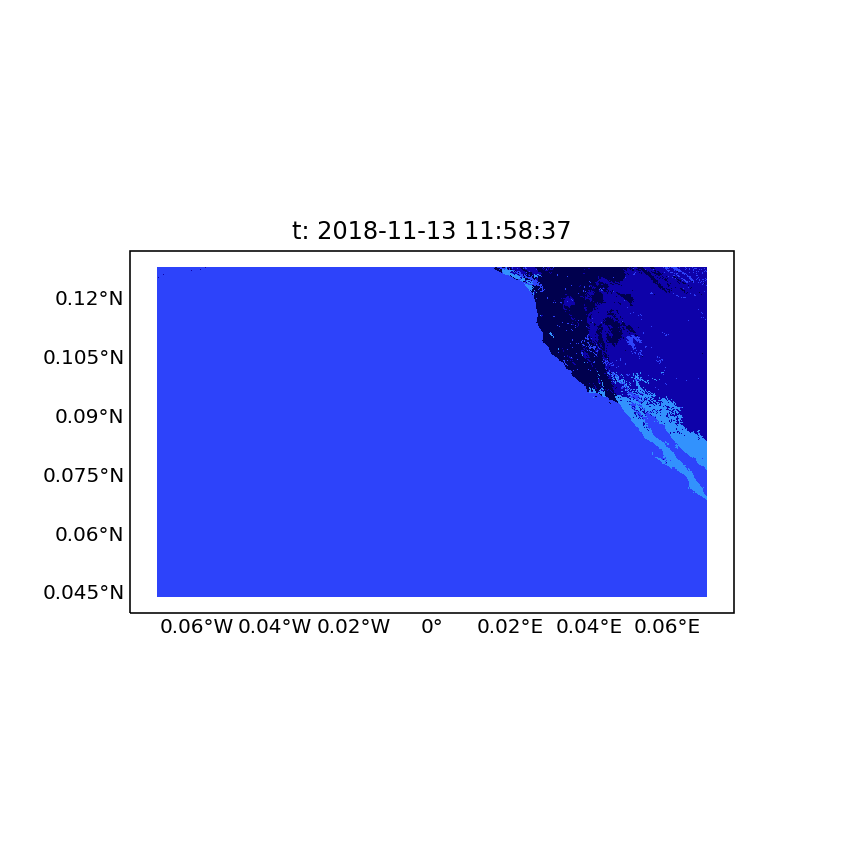
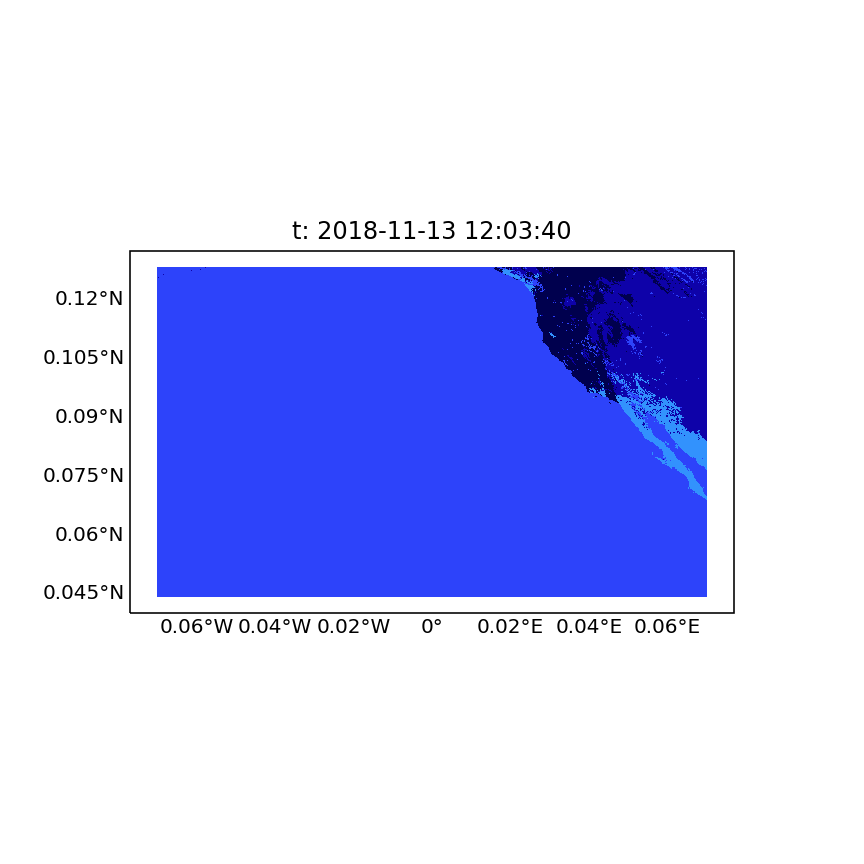
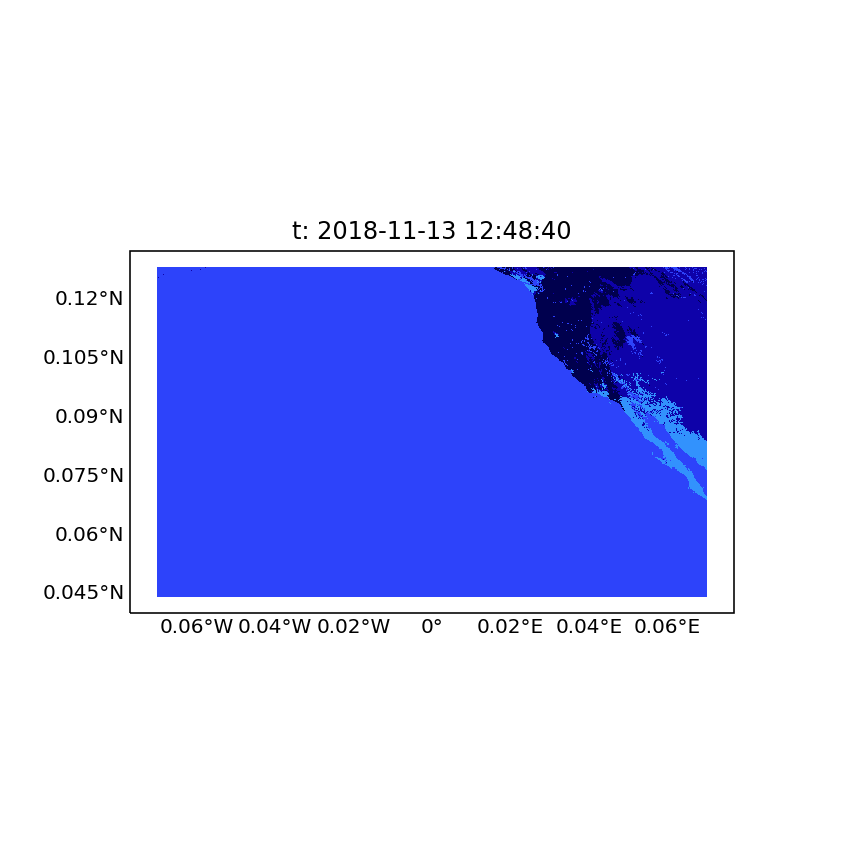
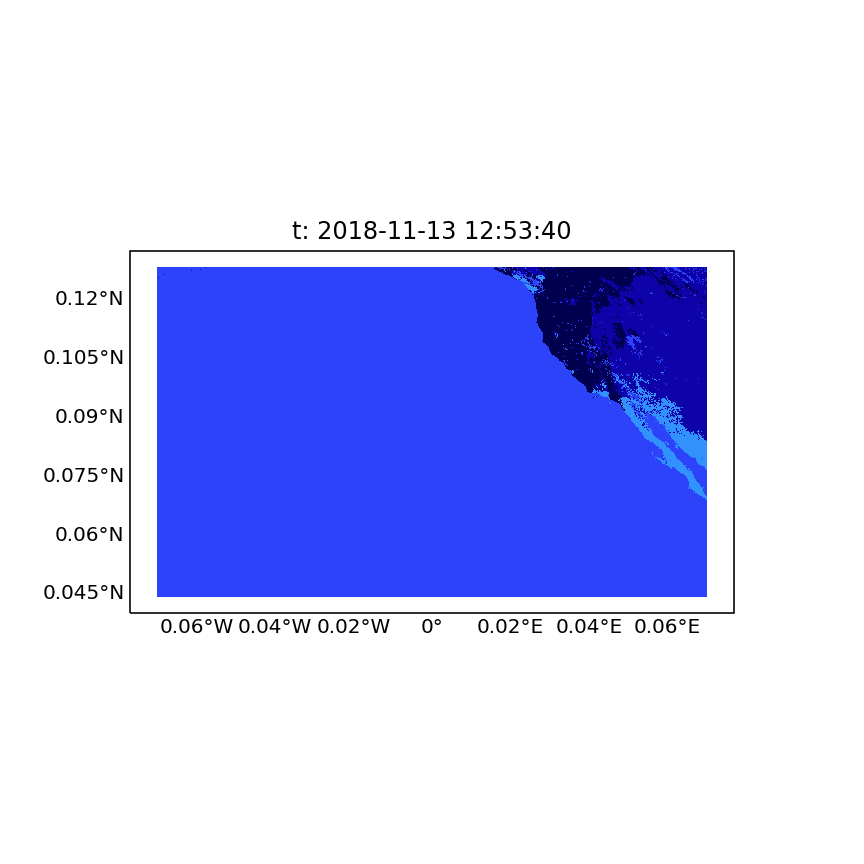
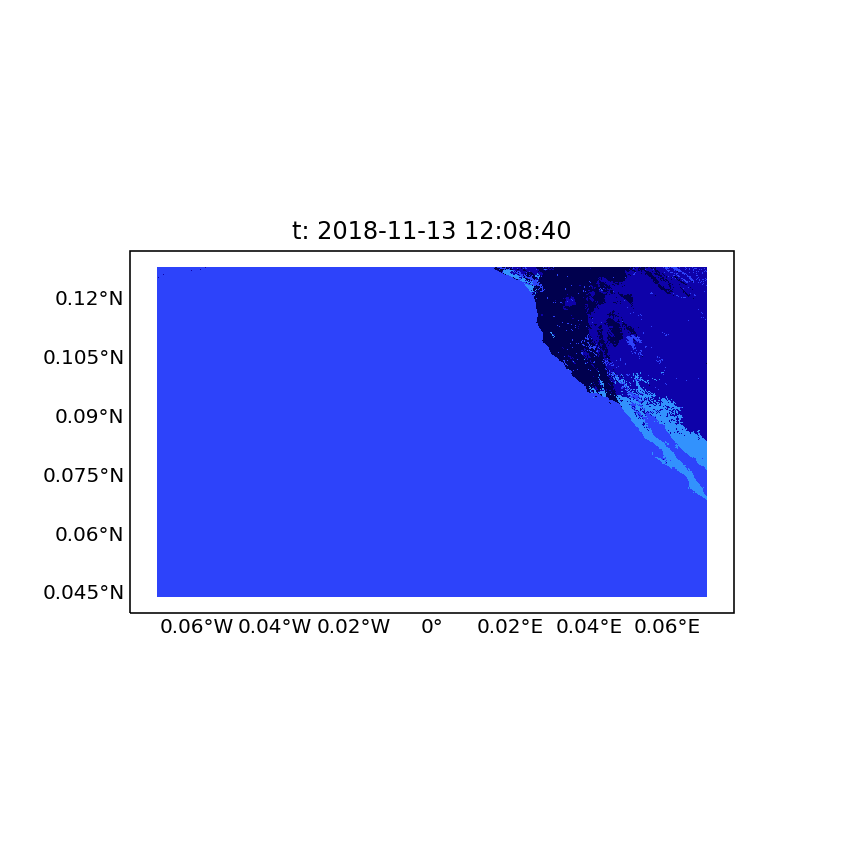
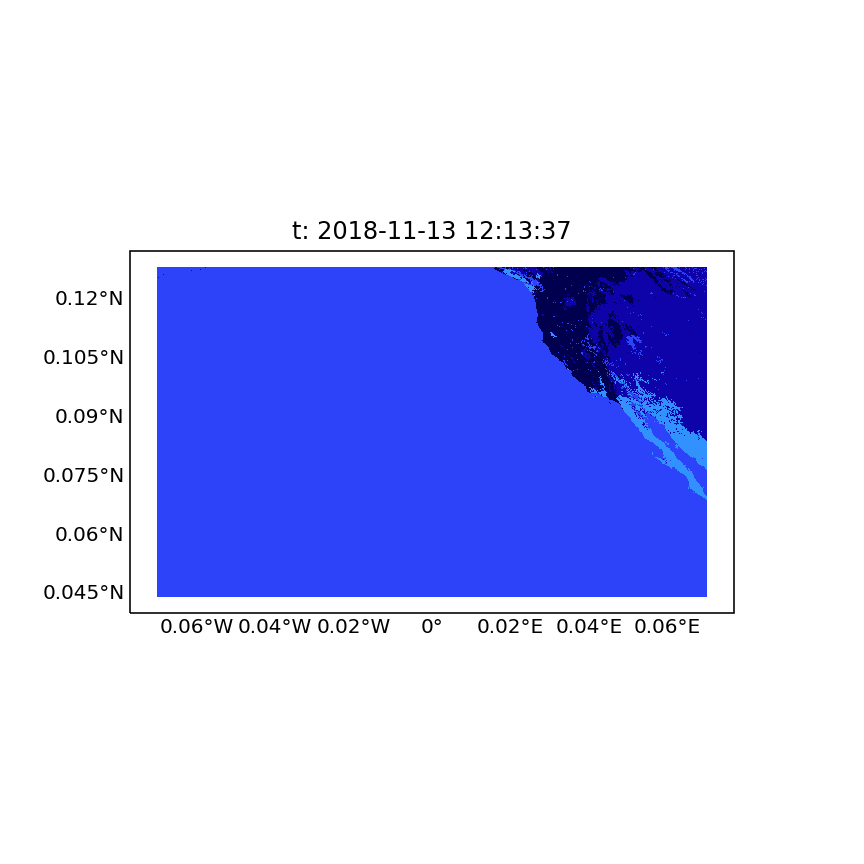
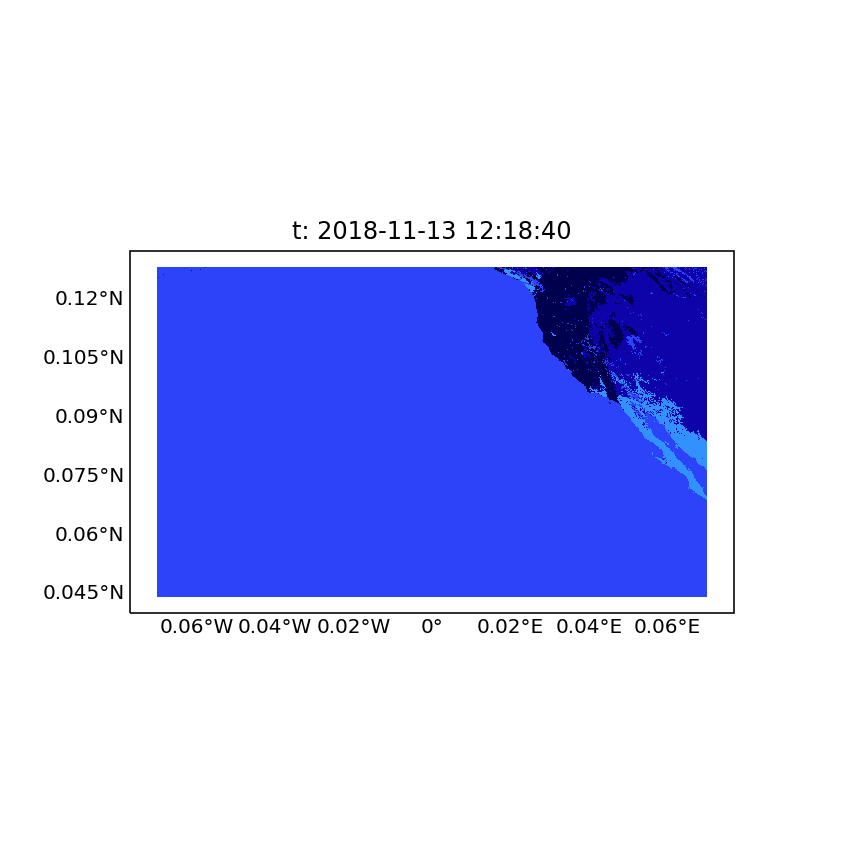
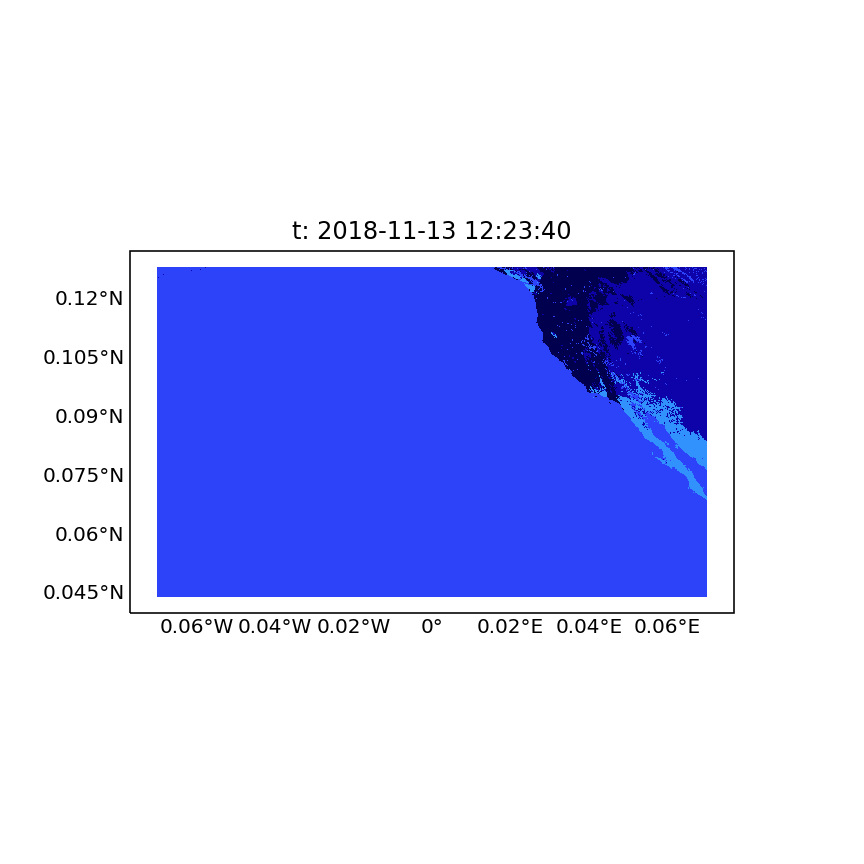
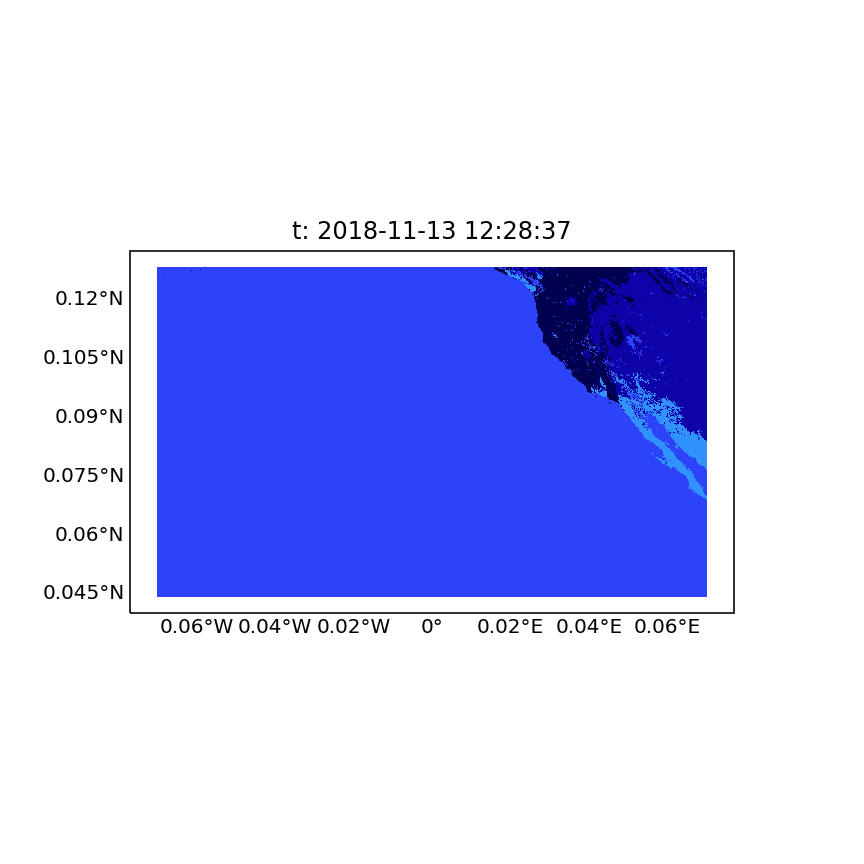
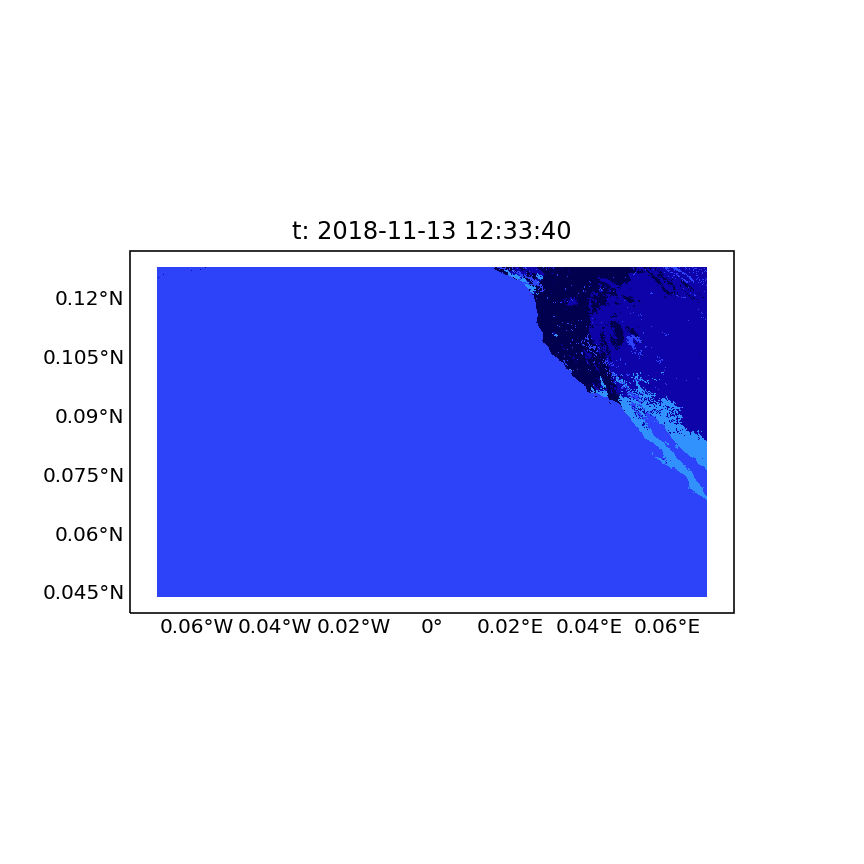
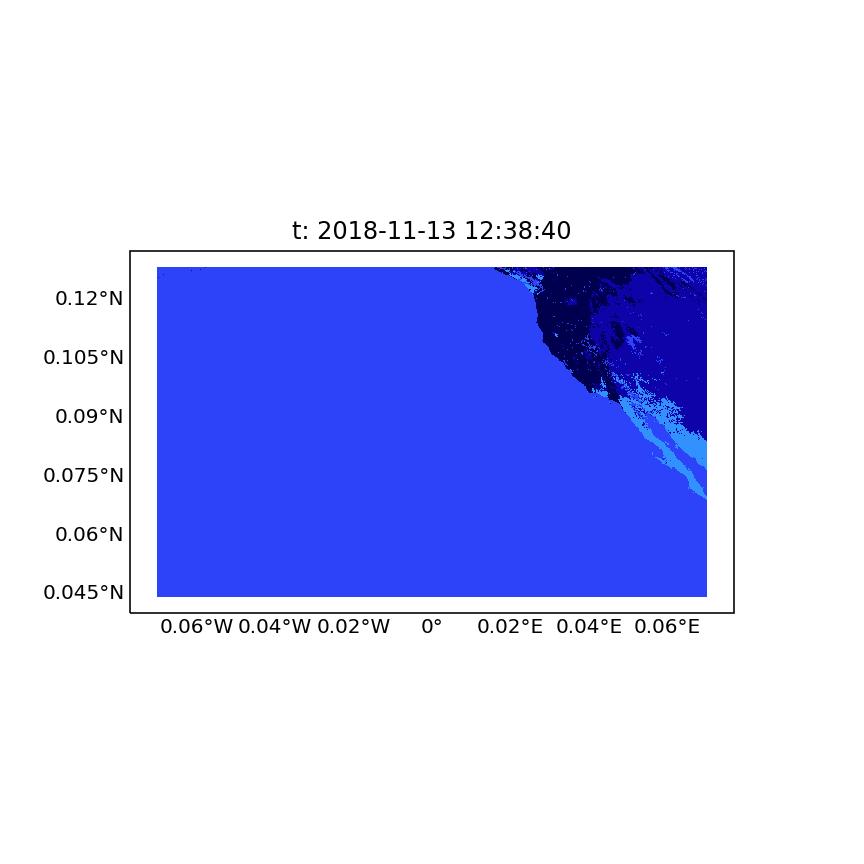
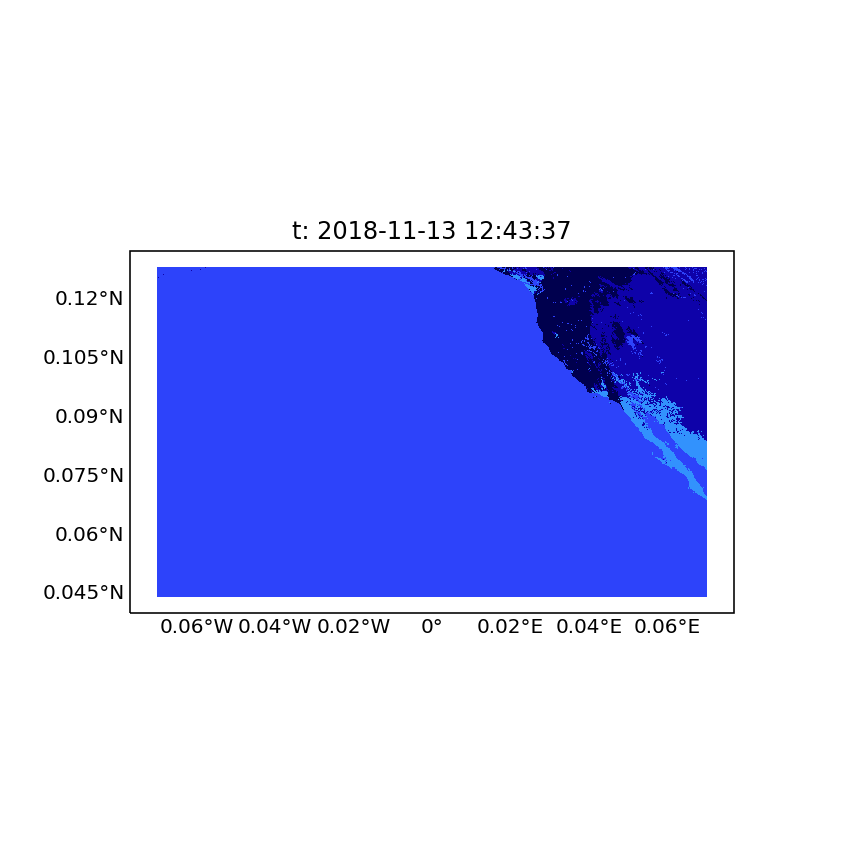
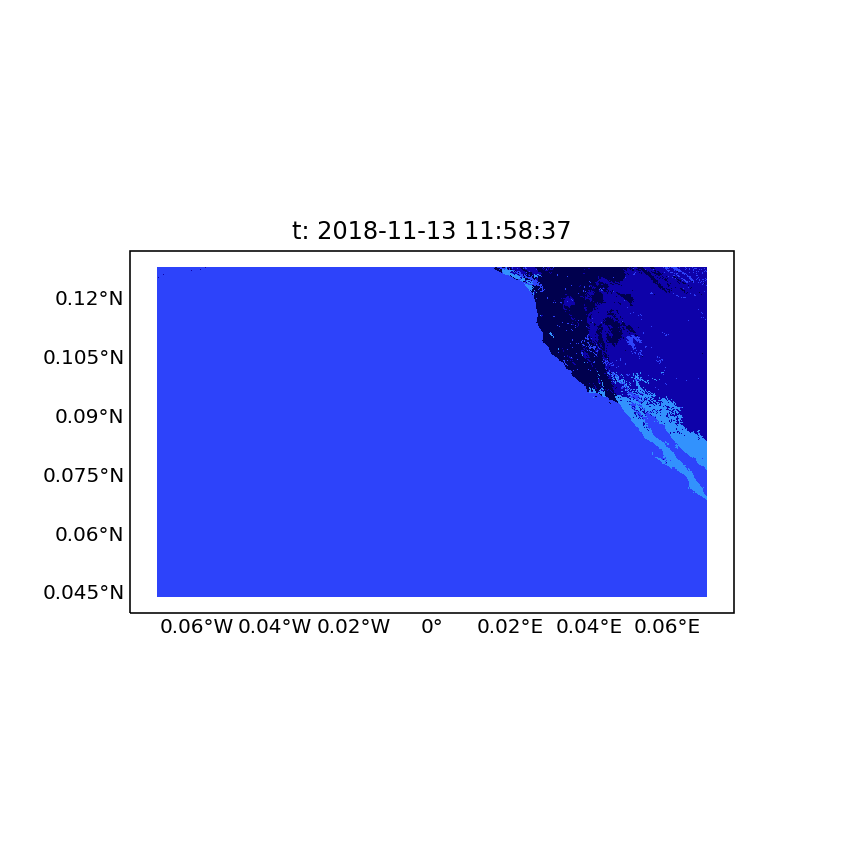

In [125]:
# To see part of the Camp Fire:
visualize_xarray(load_local_file_into_xarray(2018, 317, 12, local_filepaths), ['Mask'])

To see multiple hours or days of the fire, you can concatenate them and feed it into the visualizer:

In [143]:
#To see three consecutive hours:
fires = []
for i in range(11, 14):
    fires.append(load_local_file_into_xarray(2018, 317, i, local_filepaths))

visualize_xarray(xr.combine_by_coords(fires), ['Mask'])

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [141]:
fires[0]

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, time: 8, x: 2500, y: 1500)
Coordinates:
    t                                                 (time) datetime64[ns] 2...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.06997 .....
    y_image                                           float32 0.08624
    x_image                                           float32 0.0
    sunglint_angle                                    float32 10.0
    local_zenith_angle                                float32 80.0
    solar_zenith_angle                                float32 10.0
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds, time
Data variables:
    Area                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Temp                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Mask                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Power                                             (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    DQF                                               (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    time_bounds                                       (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                            (time) int32 -214748364...
    y_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_subpoint_lat                    (time) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (time) float64 -137.2 ....
    nominal_satellite_height                          (time) float64 3.579e+0...
    geospatial_lat_lon_extent                         (time) float32 9.969e+3...
    sunglint_angle_bounds                             (time, number_of_sunglint_angle_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    local_zenith_angle_bounds                         (time, number_of_LZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    total_number_of_pixels_with_fires_detected        (time) float64 0.0 ... 0.0
    total_number_of_pixels_with_fire_temperature      (time) float64 0.0 ... 0.0
    total_number_of_pixels_with_fire_area             (time) float64 0.0 ... 0.0
    total_number_of_pixels_with_fire_radiative_power  (time) float64 0.0 ... 0.0
    fire_temperature_outlier_pixel_count              (time) float64 0.0 ... 0.0
    fire_area_outlier_pixel_count                     (time) float64 0.0 ... 0.0
    fire_radiative_power_outlier_pixel_count          (time) float64 0.0 ... 0.0
    minimum_fire_temperature                          (time) float64 nan ... nan
    maximum_fire_temperature                          (time) float64 nan ... nan
    mean_fire_temperature                             (time) float64 nan ... nan
    standard_deviation_fire_temperature               (time) float64 nan ... nan
    minimum_fire_area                                 (time) float64 nan ... nan
    maximum_fire_area                                 (time) float64 nan ... nan
    mean_fire_area                     

In [142]:
fires[1]

<xarray.Dataset>
Dimensions:                                           (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_sunglint_angle_bounds: 2, number_of_time_bounds: 2, time: 12, x: 2500, y: 1500)
Coordinates:
    t                                                 (time) datetime64[ns] 2...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.06997 .....
    y_image                                           float32 0.08624
    x_image                                           float32 0.0
    sunglint_angle                                    float32 10.0
    local_zenith_angle                                float32 80.0
    solar_zenith_angle                                float32 10.0
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_sunglint_angle_bounds, number_of_time_bounds, time
Data variables:
    Area                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Temp                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Mask                                              (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    Power                                             (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    DQF                                               (time, y, x) float32 dask.array<chunksize=(1, 1500, 2500), meta=np.ndarray>
    time_bounds                                       (time, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                            (time) int32 -214748364...
    y_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    x_image_bounds                                    (time, number_of_image_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    nominal_satellite_subpoint_lat                    (time) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (time) float64 -137.2 ....
    nominal_satellite_height                          (time) float64 3.579e+0...
    geospatial_lat_lon_extent                         (time) float32 9.969e+3...
    sunglint_angle_bounds                             (time, number_of_sunglint_angle_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    local_zenith_angle_bounds                         (time, number_of_LZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    solar_zenith_angle_bounds                         (time, number_of_SZA_bounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    total_number_of_pixels_with_fires_detected        (time) float64 0.0 ... 1.0
    total_number_of_pixels_with_fire_temperature      (time) float64 0.0 ... 0.0
    total_number_of_pixels_with_fire_area             (time) float64 0.0 ... 0.0
    total_number_of_pixels_with_fire_radiative_power  (time) float64 0.0 ... 1.0
    fire_temperature_outlier_pixel_count              (time) float64 0.0 ... 0.0
    fire_area_outlier_pixel_count                     (time) float64 0.0 ... 0.0
    fire_radiative_power_outlier_pixel_count          (time) float64 0.0 ... 1.0
    minimum_fire_temperature                          (time) float64 nan ... nan
    maximum_fire_temperature                          (time) float64 nan ... nan
    mean_fire_temperature                             (time) float64 nan ... nan
    standard_deviation_fire_temperature               (time) float64 nan ... nan
    minimum_fire_area                                 (time) float64 nan ... nan
    maximum_fire_area                                 (time) float64 nan ... nan
    mean_fire_area                    